In [156]:
import os
import pandas as pd
import pymatgen as mg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

print('Current working directory path:',os.getcwd())
#os.chdir("")

Current working directory path: /home/atehrani/Desktop/notebook_ML_Workshop_Ski


# Extracting data from Materials Project

In [157]:
from pymatgen import MPRester
with MPRester("CTp7t9vcAgZU3HfJ") as m:
    #data = m.query(criteria={"nelements":3,"e_above_hull":{"exist":True}},properties=["pretty_formula", "unit_cell_formula", "icsd_id"，"elasticity", "structure", "task_id", "energy", "energy_per_atom", "volume", "density", "nsites", "elements", "nelements", "spacegroup", "formation_energy_per_atom","e_above_hull", "band_gap", "dos", "$"])
    criteria={"nelements":{"$eq":2}}
    properties=["pretty_formula","density"]
    data = m.query(criteria=criteria, properties=properties)

In [158]:
type(data)
data

[{'pretty_formula': 'TaS2', 'density': 6.161495974856658},
 {'pretty_formula': 'B12W', 'density': 5.274710269170763},
 {'pretty_formula': 'HoN', 'density': 11.21839695830621},
 {'pretty_formula': 'HfIr', 'density': 17.346159958828284},
 {'pretty_formula': 'CrNi3', 'density': 8.642207572933556},
 {'pretty_formula': 'VTe2', 'density': 6.320277050010022},
 {'pretty_formula': 'TbHg2', 'density': 10.937586380755029},
 {'pretty_formula': 'PtN2', 'density': 10.564823747366063},
 {'pretty_formula': 'PdN', 'density': 9.129940913654679},
 {'pretty_formula': 'RbSb', 'density': 2.227619008586219},
 {'pretty_formula': 'CrN2', 'density': 5.064064789878653},
 {'pretty_formula': 'C3N', 'density': 2.2985205003798486},
 {'pretty_formula': 'VN', 'density': 6.238656999159655},
 {'pretty_formula': 'CrC', 'density': 6.388803148276874},
 {'pretty_formula': 'HoGa', 'density': 8.171440883694455},
 {'pretty_formula': 'CeO2', 'density': 5.962113689111615},
 {'pretty_formula': 'DyS2', 'density': 6.339343163171489

In [159]:
# Converting the data (list) to a dataframe
df = pd.DataFrame(data)
df

pretty_formula    density
0               TaS2   6.161496
1               B12W   5.274710
2                HoN  11.218397
3               HfIr  17.346160
4              CrNi3   8.642208
...              ...        ...
19210           SnO2   6.137227
19211           TiO2   3.459863
19212           CrO2   3.398821
19213           BiO2   7.182301
19214           SbO2   4.567405

[19215 rows x 2 columns]

# Creating the descriptros based on composition

In [160]:
class Vectorize_Formula:

	def __init__(self):
		elem_dict = pd.read_excel(r'elementsnew.xlsx') # CHECK NAME OF FILE 
		self.element_df = pd.DataFrame(elem_dict) 
		self.element_df.set_index('Symbol',inplace=True)
		self.column_names = []
		for string in ['avg','diff','max','min']:
			for column_name in list(self.element_df.columns.values):
				self.column_names.append(string+'_'+column_name)

	def get_features(self, formula):
		try:
			fractional_composition = mg.Composition(formula).fractional_composition.as_dict()
			element_composition = mg.Composition(formula).element_composition.as_dict()
			avg_feature = np.zeros(len(self.element_df.iloc[0]))
			sum_feature = np.zeros(len(self.element_df.iloc[0]))
			for key in fractional_composition:
				try:
					avg_feature += self.element_df.loc[key].values * fractional_composition[key]                  
					diff_feature = self.element_df.loc[list(fractional_composition.keys())].max()-self.element_df.loc[list(fractional_composition.keys())].min()
				except Exception as e: 
					print('The element:', key, 'from formula', formula,'is not currently supported in our database')
					return np.array([np.nan]*len(self.element_df.iloc[0])*4)
			max_feature = self.element_df.loc[list(fractional_composition.keys())].max()
			min_feature = self.element_df.loc[list(fractional_composition.keys())].min()

			features = pd.DataFrame(np.concatenate([avg_feature, diff_feature, np.array(max_feature), np.array(min_feature)]))
			features = np.concatenate([avg_feature, diff_feature, np.array(max_feature), np.array(min_feature)])
			return features.transpose()
		except:
			print('There was an error with the Formula: '+ formula + ', this is a general exception with an unkown error')
			return [np.nan]*len(self.element_df.iloc[0])*4

In [161]:
gf=Vectorize_Formula()
# empty list for storage of features
features=[]

# empty list for storage of property values
targets=[]

# add values to list using for loop
for formula, target in zip(df['pretty_formula'], df['density']):
    features.append(gf.get_features(formula))
    targets.append(target)

# feature vectors and targets as X and y 
X = pd.DataFrame(features, columns = gf.column_names)
y = pd.Series(targets)
pd.set_option('display.max_columns', None)
X

The element: Pu from formula PuTe2 is not currently supported in our database
The element: Ac from formula AcLa3 is not currently supported in our database
The element: Ac from formula BaAc3 is not currently supported in our database
The element: Ac from formula CsAc3 is not currently supported in our database
The element: Np from formula Np3Hg is not currently supported in our database
The element: Np from formula NpAg3 is not currently supported in our database
The element: Np from formula Np3As is not currently supported in our database
The element: Pa from formula PaCd is not currently supported in our database
The element: Pa from formula PaGa3 is not currently supported in our database
The element: Pa from formula PaTi3 is not currently supported in our database
The element: Pu from formula Pu3Zr is not currently supported in our database


/home/atehrani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


The element: Pu from formula Pu4Sb3 is not currently supported in our database
The element: Pu from formula Pu4Co is not currently supported in our database
The element: Np from formula NpSi is not currently supported in our database
The element: Pu from formula PuOs2 is not currently supported in our database
The element: Pu from formula Pu2Se3 is not currently supported in our database
The element: Pu from formula PuGa is not currently supported in our database
The element: Np from formula Np2Se3 is not currently supported in our database
The element: Pu from formula PuAu3 is not currently supported in our database
The element: Pa from formula PaSe3 is not currently supported in our database
The element: Pa from formula PaCo3 is not currently supported in our database
The element: Pa from formula PaFe3 is not currently supported in our database
The element: Pu from formula PuPd is not currently supported in our database
The element: Pu from formula PuSn2 is not currently supported in

The element: Np from formula NpAg3 is not currently supported in our database
The element: Np from formula PmNp is not currently supported in our database
The element: Pu from formula YPu3 is not currently supported in our database
The element: Pu from formula PuCu6 is not currently supported in our database
The element: Np from formula NpSb is not currently supported in our database
The element: Pu from formula PuPt5 is not currently supported in our database
The element: Ac from formula AcAl3 is not currently supported in our database
The element: Pa from formula PaPd3 is not currently supported in our database
The element: Ac from formula AcAu3 is not currently supported in our database
The element: Pa from formula Pa3Ta is not currently supported in our database
The element: Pu from formula PuBi is not currently supported in our database
The element: Ac from formula Ac3I is not currently supported in our database
The element: Ac from formula AcCe3 is not currently supported in our 

The element: Pa from formula PaAs is not currently supported in our database
The element: Pu from formula PuAs is not currently supported in our database
The element: Pu from formula PuSe is not currently supported in our database
The element: Pu from formula PuAl3 is not currently supported in our database
The element: Ac from formula AcHg3 is not currently supported in our database
The element: Np from formula Np3S5 is not currently supported in our database
The element: Np from formula NpS is not currently supported in our database
The element: Pu from formula PuB12 is not currently supported in our database
The element: Ac from formula Ac3Zr is not currently supported in our database
The element: Ac from formula Ac3Cd is not currently supported in our database
The element: Pu from formula Pu3Ta is not currently supported in our database
The element: Pa from formula Sr3Pa is not currently supported in our database
The element: Np from formula NpB4 is not currently supported in our d

The element: Np from formula Np3Cd is not currently supported in our database
The element: Pu from formula SmPu is not currently supported in our database
The element: Pa from formula ThPa3 is not currently supported in our database
The element: Np from formula Np2S5 is not currently supported in our database
The element: Pu from formula Pu3Pd4 is not currently supported in our database
The element: Pu from formula PuIn is not currently supported in our database
The element: Pu from formula PuGa3 is not currently supported in our database
The element: Pu from formula PuIr2 is not currently supported in our database
The element: Pu from formula Pu13Zn58 is not currently supported in our database
The element: Ac from formula AcIn3 is not currently supported in our database
The element: Ac from formula AcMg3 is not currently supported in our database
The element: Pa from formula PaC2 is not currently supported in our database
The element: Np from formula NpTe2 is not currently supported i

The element: Pu from formula Pu3In is not currently supported in our database
The element: Pu from formula PuGa6 is not currently supported in our database
The element: Pa from formula PaO2 is not currently supported in our database
The element: Ac from formula AcAg is not currently supported in our database
The element: Pa from formula Pa3Re is not currently supported in our database
The element: Ac from formula Ac2S3 is not currently supported in our database
The element: Pu from formula YbPu3 is not currently supported in our database
The element: Np from formula LaNp3 is not currently supported in our database
The element: Ac from formula Ac3Pr is not currently supported in our database
The element: Ac from formula Ac3Cl is not currently supported in our database
The element: Np from formula HfNp3 is not currently supported in our database
The element: Pa from formula PaTa is not currently supported in our database
The element: Pu from formula PuRh3 is not currently supported in ou

The element: Pu from formula PuN is not currently supported in our database
The element: Pu from formula PuRh2 is not currently supported in our database
The element: Pu from formula PuSb is not currently supported in our database
The element: Pu from formula Pu5Ir3 is not currently supported in our database
The element: Pu from formula PuZn2 is not currently supported in our database
The element: Pa from formula NdPa3 is not currently supported in our database
The element: Np from formula NpN2 is not currently supported in our database
The element: Np from formula NpH3 is not currently supported in our database
The element: Np from formula NpB2 is not currently supported in our database
The element: Ac from formula Ac3Tm is not currently supported in our database
The element: Ac from formula Ac3Nb is not currently supported in our database
The element: Ac from formula LiAc3 is not currently supported in our database
The element: Ac from formula NaAc3 is not currently supported in our 

avg_Atomic_Number  avg_Atomic_Weight  avg_Period  avg_group  \
0              35.000000          81.693300    4.000000  12.333333   
1              10.307692          24.120923    2.307692  12.461538   
2              37.000000          89.468530    4.000000   9.000000   
3              74.500000         185.355000    6.000000   6.500000   
4              27.000000          57.019075    4.000000   9.000000   
...                  ...                ...         ...        ...   
19210          22.000000          50.236267    3.000000  15.333333   
19211          12.666667          26.626267    2.666667  12.000000   
19212          13.333333          27.998300    2.666667  12.666667   
19213          33.000000          80.326390    3.333333  15.666667   
19214          22.333333          51.252933    3.000000  15.666667   

       avg_families  avg_Mendeleev Number  avg_Atomic Radus  \
0          6.000000             74.666667          1.150000   
1          5.846154             70.384615          0.888462   
2          5.000000             57.500000          1.200000   
3          4.000000             52.500000          1.450000   
4          4.000000             58.000000          1.362500   
...             ...                   ...               ...   
19210      6.333333             84.666667          0.883333   
19211      6.000000             72.333333          0.866667   
19212      6.000000             74.333333          0.866667   
19213      6.333333             86.666667          0.933333   
19214      6.666667             86.333333          0.883333   

       avg_ Covalent_Radius  avg_Zunger radii sum  avg_ionic radius  \
0                  1.126667              1.663333          1.150000   
1                  0.856923              0.944231          0.888462   
2                  1.165000              2.095000          1.200000   
3                  1.355000              2.769000          1.450000   
4                  1.157500              2.245000          1.362500   
...                     ...                   ...               ...   
19210              0.956667              0.936667          0.883333   
19211              0.926667              1.170000          0.866667   
19212              0.880000              1.123333          0.866667   
19213              0.973333              0.975667          0.933333   
19214              0.953333              0.898333          0.883333   

       avg_crystal radius  avg_ Pauling_Electronegativity  \
0                0.546667                        2.220000   
1                0.287692                        2.013846   
2                0.670000                        2.135000   
3                0.810000                        1.750000   
4                0.715000                        1.847500   
...                   ...                             ...   
19210            1.036667                        2.946667   
19211            1.056667                        2.806667   
19212            1.060000                        2.846667   
19213            1.196667                        2.966667   
19214            1.106667                        2.976667   

       avg_metallic valence  avg_number of valence electrons  \
0                  3.000000                         5.666667   
1                  3.213846                         3.230769   
2                  3.000000                         4.000000   
3                  4.890000                         6.500000   
4                  5.780000                         9.000000   
...                     ...                              ...   
19210              1.333333                         5.333333   
19211              1.333333                         5.333333   
19212              1.926667                         6.000000   
19213              1.000000                         5.666667   
19214              1.000000                         5.666667   

       avg_gilman number of valence electron  avg_vale

In [162]:
# drop elements that aren't included in the elemental properties list. 
# These will be returned as feature rows completely full of NaN values. 
X.dropna(inplace=True, how='all')
y=y.loc[X.index]

# reset dataframe indices to simplify code later.
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [163]:
# collect column names
cols = X.columns.values

# find the median value of each column
median_values = X[cols].median()

# fill missing values in each column with columns mean value
X[cols]=X[cols].fillna(median_values.iloc[0])
X

avg_Atomic_Number  avg_Atomic_Weight  avg_Period  avg_group  \
0              35.000000          81.693300    4.000000  12.333333   
1              10.307692          24.120923    2.307692  12.461538   
2              37.000000          89.468530    4.000000   9.000000   
3              74.500000         185.355000    6.000000   6.500000   
4              27.000000          57.019075    4.000000   9.000000   
...                  ...                ...         ...        ...   
18620          22.000000          50.236267    3.000000  15.333333   
18621          12.666667          26.626267    2.666667  12.000000   
18622          13.333333          27.998300    2.666667  12.666667   
18623          33.000000          80.326390    3.333333  15.666667   
18624          22.333333          51.252933    3.000000  15.666667   

       avg_families  avg_Mendeleev Number  avg_Atomic Radus  \
0          6.000000             74.666667          1.150000   
1          5.846154             70.384615          0.888462   
2          5.000000             57.500000          1.200000   
3          4.000000             52.500000          1.450000   
4          4.000000             58.000000          1.362500   
...             ...                   ...               ...   
18620      6.333333             84.666667          0.883333   
18621      6.000000             72.333333          0.866667   
18622      6.000000             74.333333          0.866667   
18623      6.333333             86.666667          0.933333   
18624      6.666667             86.333333          0.883333   

       avg_ Covalent_Radius  avg_Zunger radii sum  avg_ionic radius  \
0                  1.126667              1.663333          1.150000   
1                  0.856923              0.944231          0.888462   
2                  1.165000              2.095000          1.200000   
3                  1.355000              2.769000          1.450000   
4                  1.157500              2.245000          1.362500   
...                     ...                   ...               ...   
18620              0.956667              0.936667          0.883333   
18621              0.926667              1.170000          0.866667   
18622              0.880000              1.123333          0.866667   
18623              0.973333              0.975667          0.933333   
18624              0.953333              0.898333          0.883333   

       avg_crystal radius  avg_ Pauling_Electronegativity  \
0                0.546667                        2.220000   
1                0.287692                        2.013846   
2                0.670000                        2.135000   
3                0.810000                        1.750000   
4                0.715000                        1.847500   
...                   ...                             ...   
18620            1.036667                        2.946667   
18621            1.056667                        2.806667   
18622            1.060000                        2.846667   
18623            1.196667                        2.966667   
18624            1.106667                        2.976667   

       avg_metallic valence  avg_number of valence electrons  \
0                  3.000000                         5.666667   
1                  3.213846                         3.230769   
2                  3.000000                         4.000000   
3                  4.890000                         6.500000   
4                  5.780000                         9.000000   
...                     ...                              ...   
18620              1.333333                         5.333333   
18621              1.333333                         5.333333   
18622              1.926667                         6.000000   
18623              1.000000                         5.666667   
18624              1.000000                         5.666667   

       avg_gilman number of valence electron  avg_vale

In [164]:
y

0         6.161496
1         5.274710
2        11.218397
3        17.346160
4         8.642208
           ...    
18620     6.137227
18621     3.459863
18622     3.398821
18623     7.182301
18624     4.567405
Length: 18625, dtype: float64

In [165]:
X.shape
#y.shape

(18625, 124)

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=27, shuffle=True)

In [167]:
X_train.shape

(13037, 124)

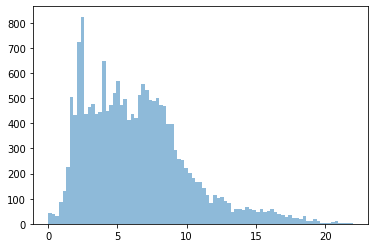

In [168]:
plt.hist(y, bins=85, alpha = 0.5);

# Preprocessing

In [169]:
scaler = preprocessing.StandardScaler().fit(X_train)
scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
normalizer = preprocessing.Normalizer().fit(X_train)
normalizer
X_train=normalizer.transform(X_train)
X_test=normalizer.transform(X_test)

# Regression models

R2 on training set:0.910336
R2 on test set:0.906828
mse: 1.224035, rmse: 1.106361


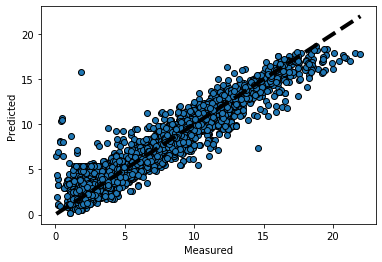

In [170]:
#linear regression
linear_regression = LinearRegression().fit(X_train, y_train)
predict_y = linear_regression.predict(X_test)
mse = mean_squared_error(y_test, predict_y)
rmse = np.sqrt(mse)
print("R2 on training set:%f" % linear_regression.score(X_train, y_train))
print("R2 on test set:%f" % linear_regression.score(X_test, y_test))
print("mse: %f, rmse: %f" % (mse, rmse))

#predicted = cross_val_predict(linear_regression, X_test, y_test, cv=5)
fig, ax = plt.subplots()
ax.scatter(y_test, predict_y, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

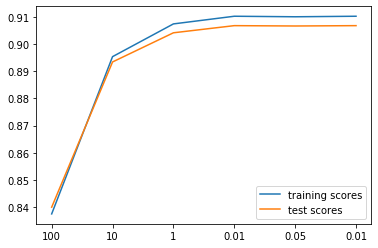

In [171]:
#Ridge
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01,0.05, 0.01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(6), [100, 10, 1, .01, 0.05,0.01])
plt.legend(loc="best")

In [172]:
#rbf svr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [10, 100], 'gamma': [1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
y_predict = grid.predict
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'C': 10, 'gamma': 1}
0.9621246963821289


R2 on test set:0.962125


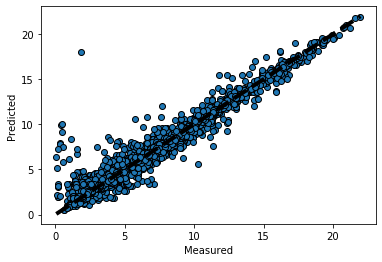

In [173]:
SVM = SVR(**grid.best_params_).fit(X_train, y_train)
predict_y = SVM.predict(X_test)
print("R2 on test set:%f" % SVM.score(X_test, y_test))
fix, ax = plt.subplots()
ax.scatter(y_test, predict_y, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# New predictions

In [174]:
gf = Vectorize_Formula()

p = [{'pretty_formula': 'Al2O3', 'density': 0},
 {'pretty_formula': 'Al4O', 'density': 0},
 {'pretty_formula': 'W5C', 'density': 0}]
type(p)
#print(p)
dp = pd.DataFrame(p)
dp
# empty list for storage of features
gf=Vectorize_Formula()
# empty list for storage of features
features=[]

# empty list for storage of property values
targets=[]

# add values to list using for loop
for formula, target in zip(dp['pretty_formula'], dp['density']):
    features.append(gf.get_features(formula))
    targets.append(target)

# feature vectors and targets as X and y 
P = pd.DataFrame(features, columns = gf.column_names)
y = pd.Series(targets)
pd.set_option('display.max_columns', None)
P

avg_Atomic_Number  avg_Atomic_Weight  avg_Period  avg_group  avg_families  \
0          10.000000          20.392256    2.400000  14.800000           6.2   
1          12.000000          24.785111    2.800000  13.600000           5.4   
2          62.666667         155.201833    5.333333   7.333333           4.5   

   avg_Mendeleev Number  avg_Atomic Radus  avg_ Covalent_Radius  \
0             81.400000          0.860000              0.910000   
1             75.800000          1.120000              1.090000   
2             55.333333          1.241667              1.211667   

   avg_Zunger radii sum  avg_ionic radius  avg_crystal radius  \
0              0.949000          0.860000               0.938   
1              1.433000          1.120000               0.666   
2              2.385833          1.241667               0.665   

   avg_ Pauling_Electronegativity  avg_metallic valence  \
0                        2.708000              1.200000   
1                        1.976000              2.400000   
2                        1.841667              5.483333   

   avg_number of valence electrons  avg_gilman number of valence electron  \
0                         4.800000                                    4.8   
1                         3.600000                                    3.6   
2                         5.666667                                    4.0   

   avg_valence s  avg_valence p  avg_valence d  avg_outer shell electrons  \
0            2.0       2.800000       0.000000                   4.800000   
1            2.0       1.600000       0.000000                   3.600000   
2            2.0       0.333333       3.333333                   2.333333   

   avg_1st ionization potential (kJ/mol)  avg_polarizability\n(A^3)  \
0                            1019.600000                     3.7958   
1                             725.200000                     6.7986   
2                             822.666667                     9.5500   

   avg_Melting point (K)  avg_Boiling Point (K)  avg_Density (g/mL)  \
0             406.110000            1150.150000            1.080858   
1             757.470000            2210.150000            2.160286   
2            3675.983333            5794.316667           16.668833   

   avg_specific heat (J/g K)   avg_heat of fusion (kJ/mol)   \
0                       0.912                      4.449554   
1                       0.904                      8.676518   
2                       0.195                     49.500000   

   avg_heat of vaporization (kJ/mol)   avg_thermal conductivity (W/(m K))   \
0                          119.405940                            94.816044   
1                          235.401980                           189.605348   
2                          745.966667                           148.333333   

   avg_enthalpy of atomization (kJ/mol)   avg_Cohesive energy  \
0                                  279.8                2.928   
1                                  310.6                3.236   
2                                  827.0                8.645   

   avg_electron affinity (kJ/mol)  diff_Atomic_Number  diff_Atomic_Weight  \
0                      101.290400                 5.0           10.982139   
1                       61.604800                 5.0           10.982139   
2                       85.929383                68.0          171.829000   

   diff_Period  diff_group  diff_families  diff_Mendeleev Number  \
0          1.0         3.0            2.0                   14.0   
1          1.0         3.0            2.0                   14.0   
2          4.0         8.0            3.0                   26.0   

   diff_Atomic Radus  diff_ Covalent_Radius  diff_Zunger radii sum  \
0               0.65                   0.45                  1.210   
1               0.65                   0.45                  1.210   
2               0.65                   0.53                  2.095   

   diff_ionic radius  diff_crystal ra

In [175]:
P = scaler.transform(P)
P = normalizer.transform(P)

In [176]:
predict_p = SVM.predict(P)
print(predict_p)

[ 3.09952051  2.67059033 17.62711758]
